# Food CNN

In [18]:
import tensorflow as tf
import glob

In [19]:
import pandas as pd 
import os
import numpy as np 
import cv2
from tensorflow.keras.preprocessing import image 
from tensorflow.keras import regularizers, utils

import numpy as np 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from skimage.segmentation import mark_boundaries 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load data and Augment

In [21]:
datagen=ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

crop_train_generator=datagen.flow_from_directory(
    directory="./UECFOOD100_CROP/train_crop",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(128,128))

Found 11688 images belonging to 100 classes.


## Create Food Classifier

Use transfer learning with InceptionV3 as the base model

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2


from tensorflow.keras import models
from tensorflow.keras.layers import Input
import tensorflow as tf

In [23]:
optimizer = Adam(lr = .001)

inception = InceptionResNetV2(weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False
    
x = inception.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(2048,activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(100,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)
model = models.Model(inputs=inception.input, outputs=predictions)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy', 'top_k_categorical_accuracy'])
model.summary()

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)


C:\Users\reonh\miniconda3\envs\dev\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Total params: 57,695,556
Trainable params: 3,355,748
Non-trainable params: 54,339,808
__________________________________________________________________________________________________


In [24]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Train Model

In [ ]:
history1 = model.fit(crop_train_generator,epochs=50, verbose=True,  callbacks=[early_stop, rlrop])

Epoch 1/50
366/366 [==============================] - 165s 407ms/step - loss: 4.3129 - accuracy: 0.3163 - top_k_categorical_accuracy: 0.5792
Epoch 2/50
246/366 [===================>..........] - ETA: 30s - loss: 2.9718 - accuracy: 0.4318 - top_k_categorical_accuracy: 0.7259

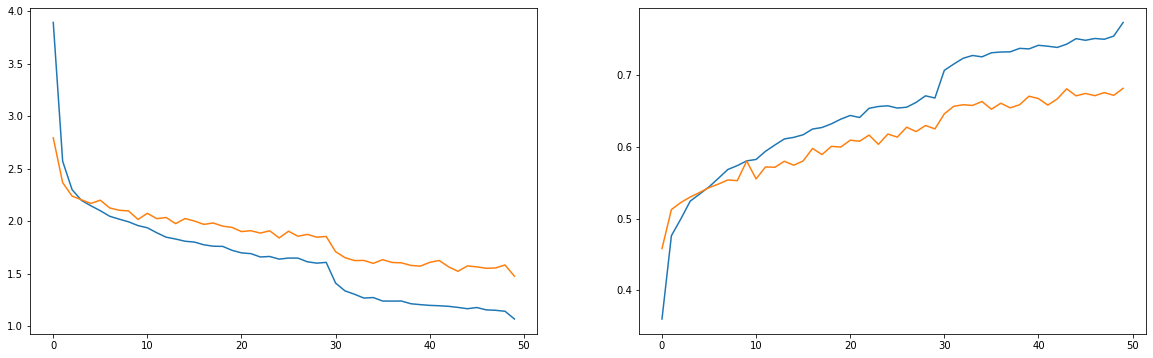

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history1.history['loss'])
axes[0].plot(history1.history['val_loss'])
axes[1].plot(history1.history['accuracy'])
axes[1].plot(history1.history['val_accuracy'])

In [132]:
history2 = model.fit(train_generator, validation_data=test_generator,epochs=50, verbose=True,  callbacks=[early_stop, rlrop])

Epoch 1/50
524/524 [==============================] - 124s 236ms/step - loss: 1.0169 - accuracy: 0.7848 - top_k_categorical_accuracy: 0.9537 - val_loss: 1.4716 - val_accuracy: 0.6955 - val_top_k_categorical_accuracy: 0.8987curacy: 0.7844 - top_k_categorical_acc - ETA: 1:11 - loss: 1.0247 - accuracy: 0.7855 - top_k_categorica - ETA: 1:07 - loss: 1.0243  - ETA: 43s - loss: 1.0081 - accuracy: 0.7885 - top_k_categorical_accuracy: 0. - - ETA: 28s - loss: 1.0092 - accuracy: 0.7877 - - ETA: 9s - loss: 1.0133 - accuracy: 0.7859 - top_k_categorical_accuracy:  - ETA: 8s - loss: 1.0133 - accuracy: 0.7856 - top_k_categorical_accuracy: 0.9 - ETA: 7s - loss: 1.0120 - accuracy: 0
Epoch 2/50
524/524 [==============================] - 125s 239ms/step - loss: 1.0012 - accuracy: 0.7837 - top_k_categorical_accuracy: 0.9574 - val_loss: 1.4270 - val_accuracy: 0.6972 - val_top_k_categorical_accuracy: 0.8978ss: 1.0095 - accuracy: 0.7799 - top_k_categorical_accuracy: 0.95 - ETA: 1:18 - loss: 1.0088 - accuracy:

524/524 [==============================] - 127s 242ms/step - loss: 0.7637 - accuracy: 0.8309 - top_k_categorical_accuracy: 0.9738 - val_loss: 1.2533 - val_accuracy: 0.7265 - val_top_k_categorical_accuracy: 0.9028.7953 -  - ETA: 1:17 - loss: 0.7674 - accuracy: 0.8290 - top_k_categorical_ac - ETA: 1:14 - loss
Epoch 47/50
524/524 [==============================] - 127s 243ms/step - loss: 0.7589 - accuracy: 0.8310 - top_k_categorical_accuracy: 0.9726 - val_loss: 1.3077 - val_accuracy: 0.7098 - val_top_k_categorical_accuracy: 0.9018
Epoch 48/50
524/524 [==============================] - 127s 242ms/step - loss: 0.7551 - accuracy: 0.8313 - top_k_categorical_accuracy: 0.9733 - val_loss: 1.2675 - val_accuracy: 0.7189 - val_top_k_categorical_accuracy: 0.9057 - accuracy: 0.8317 - top_k_categorical_accurac
Epoch 49/50
524/524 [==============================] - 128s 244ms/step - loss: 0.7592 - accuracy: 0.8313 - top_k_categorical_accuracy: 0.9722 - val_loss: 1.2905 - val_accuracy: 0.7182 - val_top_

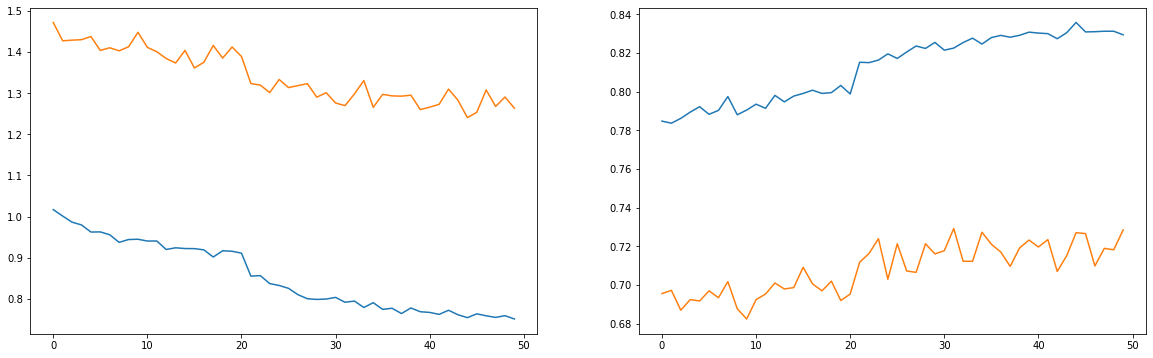

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history2.history['loss'])
axes[0].plot(history2.history['val_loss'])
axes[1].plot(history2.history['accuracy'])
axes[1].plot(history2.history['val_accuracy'])

In [141]:
history3 = model.fit(train_generator, validation_data=test_generator,epochs=50, verbose=True,  callbacks=[early_stop, rlrop])

Epoch 1/50
524/524 [==============================] - 111s 211ms/step - loss: 0.7223 - accuracy: 0.8425 - top_k_categorical_accuracy: 0.9748 - val_loss: 1.2566 - val_accuracy: 0.7268 - val_top_k_categorical_accuracy: 0.9112
Epoch 2/50
524/524 [==============================] - 112s 214ms/step - loss: 0.7267 - accuracy: 0.8386 - top_k_categorical_accuracy: 0.9755 - val_loss: 1.2782 - val_accuracy: 0.7256 - val_top_k_categorical_accuracy: 0.9042
Epoch 3/50
524/524 [==============================] - 113s 216ms/step - loss: 0.7241 - accuracy: 0.8402 - top_k_categorical_accuracy: 0.9734 - val_loss: 1.2466 - val_accuracy: 0.7246 - val_top_k_categorical_accuracy: 0.9114
Epoch 4/50
524/524 [==============================] - 113s 216ms/step - loss: 0.7209 - accuracy: 0.8417 - top_k_categorical_accuracy: 0.9748 - val_loss: 1.2506 - val_accuracy: 0.7253 - val_top_k_categorical_accuracy: 0.9076
Epoch 5/50
524/524 [==============================] - 113s 215ms/step - loss: 0.7186 - accuracy: 0.8407 

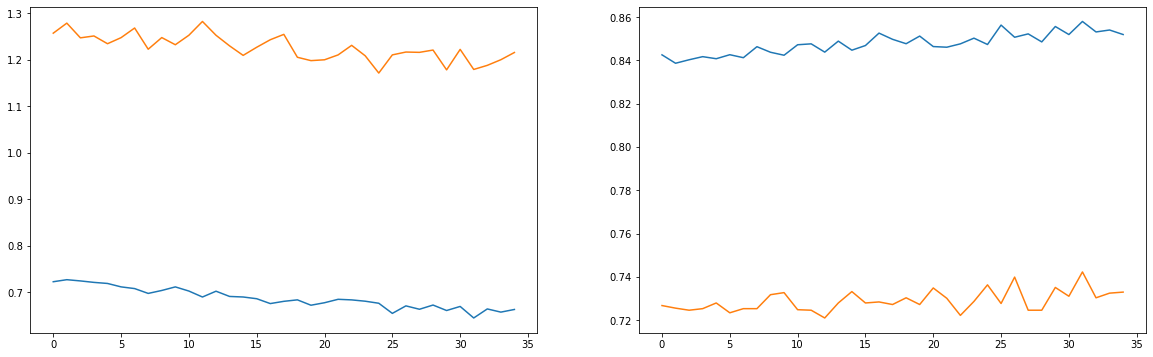

In [148]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history3.history['loss'])
axes[0].plot(history3.history['val_loss'])
axes[1].plot(history3.history['accuracy'])
axes[1].plot(history3.history['val_accuracy'])

## Test on raw dataset without augmentation

In [465]:
no_augment_datagen=ImageDataGenerator(
        rescale=1./255,
        fill_mode='nearest')

test_gen_no_augment = no_augment_datagen.flow_from_dataframe(   
    dataframe=test,
    directory=".",
    x_col="filename",
    y_col="y",
    shuffle=False,
    batch_size=32,
    class_mode="categorical",
    target_size=(128,128))

train_gen_no_augment = no_augment_datagen.flow_from_dataframe(   
    dataframe=train,
    directory=".",
    x_col="filename",
    y_col="y",
    shuffle=False,
    batch_size=32,
    class_mode="categorical",
    target_size=(128,128))

Found 4187 validated image filenames belonging to 100 classes.
Found 16744 validated image filenames belonging to 100 classes.


In [173]:
model.evaluate(test_gen_no_augment)

131/131 [==============================] - 14s 106ms/step - loss: 1.0137 - accuracy: 0.7788 - top_k_categorical_accuracy: 0.9353


[1.0136945247650146, 0.7788392901420593, 0.9352758526802063]

In [146]:
model.evaluate(train_gen_no_augment)

524/524 [==============================] - 56s 107ms/step - loss: 0.3624 - accuracy: 0.9508 - top_k_categorical_accuracy: 0.9958


[0.3623735308647156, 0.9507883191108704, 0.9958193898200989]

In [147]:
model.save('uec100')

INFO:tensorflow:Assets written to: uec100\assets


## Accuracy measures

In [195]:
ytrue =test_gen_no_augment.classes

In [194]:
ypred = model.predict(test_gen_no_augment)

In [191]:
ypred_label = [np.argmax(pred) for pred in ypred]

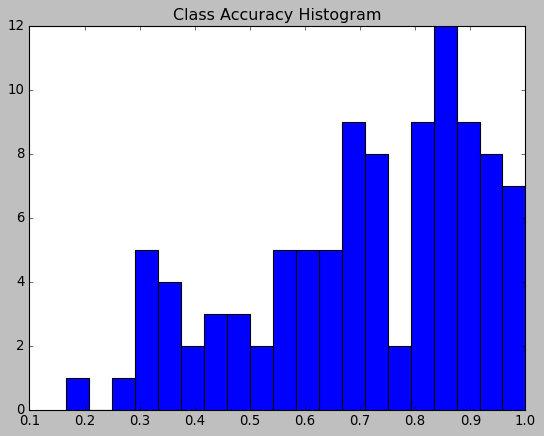

In [290]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
matrix = confusion_matrix(ytrue, ypred_label)
class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
plt.style.use('classic')
plt.title('Class Accuracy Histogram')
p = plt.hist(class_accuracies, bins=20)


In [287]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(100):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(ytrue))[:, i], ypred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

C:\Users\reonh\AppData\Local\Temp/ipykernel_47564/4213337631.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


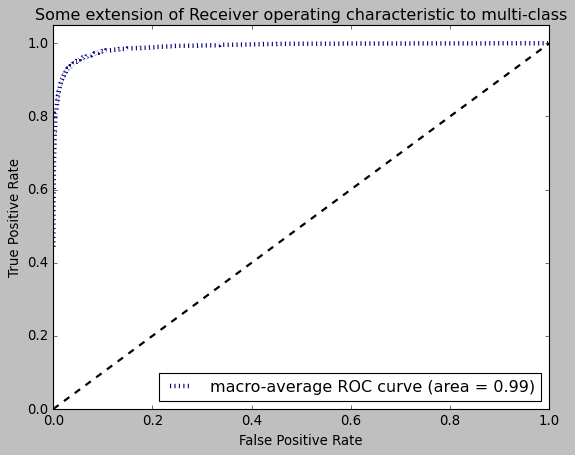

In [291]:
from scipy import interp
from itertools import cycle
lw = 2
n_classes = 100


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

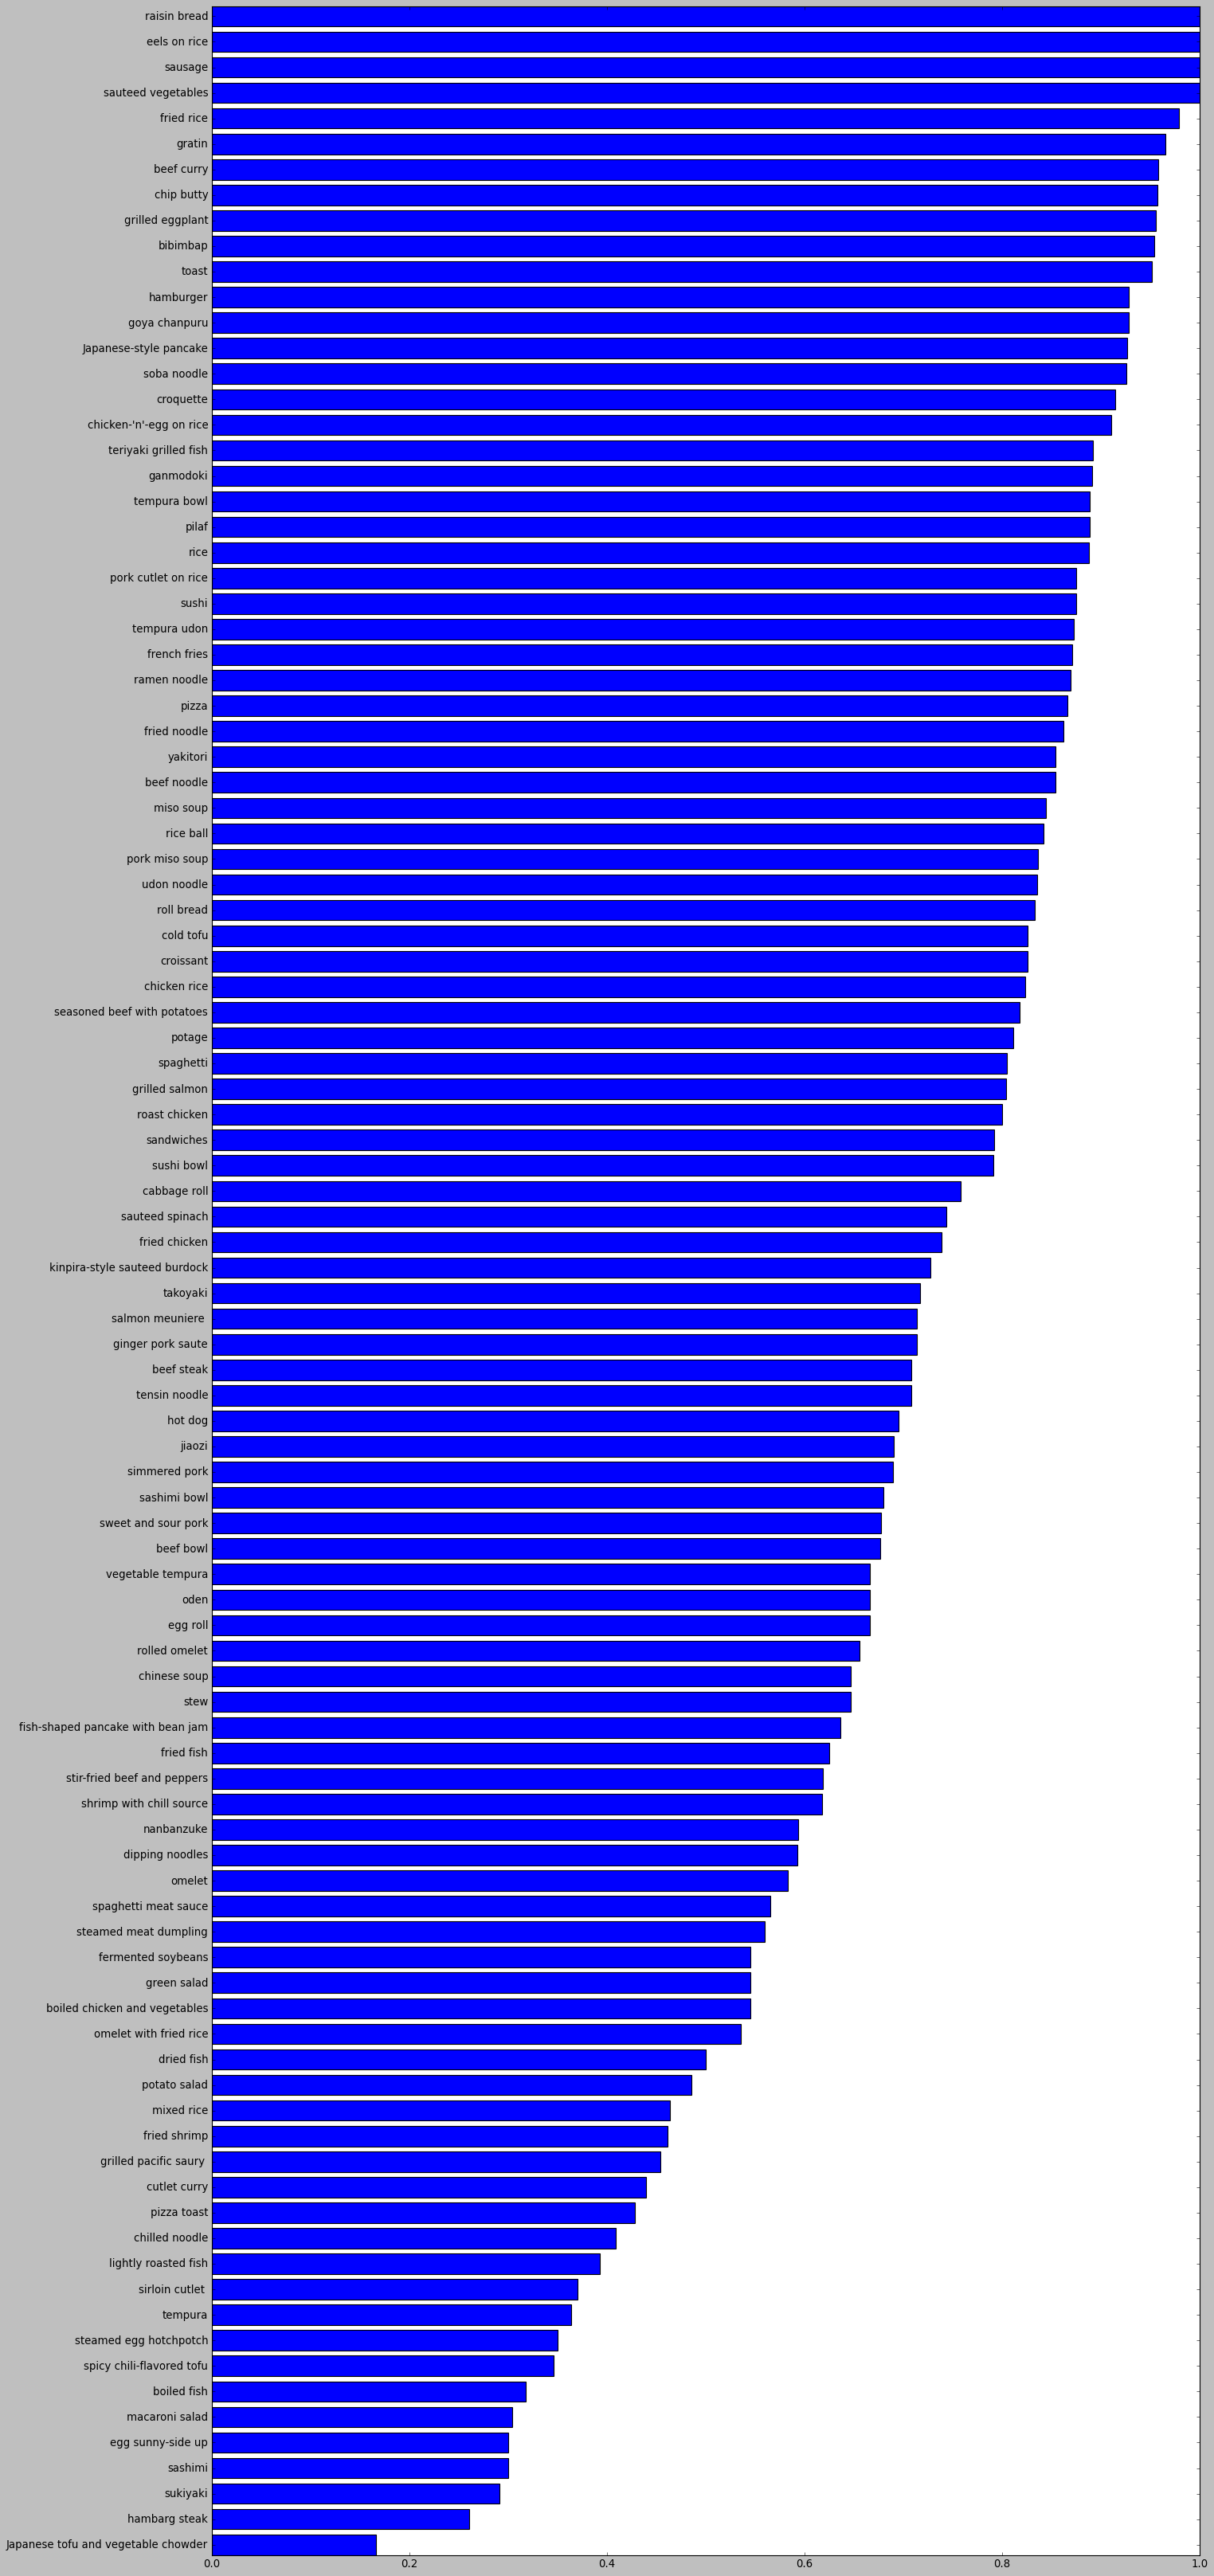

In [346]:
class_labels = pd.read_csv('./UECFOOD100_CROP/category.txt', sep='\t')
acc = class_labels.join(pd.DataFrame(class_accuracies)).rename(columns={0:'class_accuracy'}).sort_values('class_accuracy')
plt.figure(figsize=(20,50))
p = plt.barh(acc.name, acc.class_accuracy)

In [390]:
acc

,id,name,class_accuracy
88,89,Japanese tofu and vegetable chowder,0.166667
59,60,hambarg steak,0.260870
49,50,sukiyaki,0.291667
47,48,sashimi,0.300000
67,68,egg sunny-side up,0.300000
...,...,...,...
8,9,fried rice,0.979381
30,31,sauteed vegetables,1.000000
37,38,sausage,1.000000
1,2,eels on rice,1.000000


## Try random images

In [444]:
class_labels.sort_values('id')

,id,name
0,1,rice
1,2,eels on rice
2,3,pilaf
3,4,chicken-'n'-egg on rice
4,5,pork cutlet on rice
...,...,...
95,96,dipping noodles
96,97,hot dog
97,98,french fries
98,99,mixed rice


In [495]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
text_labels = imagedata[['foodclass', 'label']].astype(str).set_index('foodclass').drop_duplicates().join(class_labels.astype(str).set_index('id'))
text_labels = text_labels.sort_values('label').set_index('label')

name    fried rice
Name: 8, dtype: object


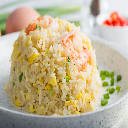

In [514]:
img =load_img('web_pics/friedrice.jpg', target_size=(128,128))
preds = model.predict(np.array([img_to_array(img)/255]))
print(text_labels.iloc[np.argmax(preds[0])])
img

name    fish-shaped pancake with bean jam
Name: 77, dtype: object


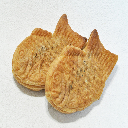

In [517]:
img =load_img('web_pics/fishpastry.jpg', target_size=(128,128))
preds = model.predict(np.array([img_to_array(img)/255]))
print(text_labels.iloc[np.argmax(preds[0])])
img

name    eels on rice
Name: 1, dtype: object


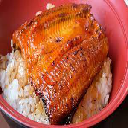

In [513]:
img =load_img('web_pics/unagi.jpg', target_size=(128,128))
preds = model.predict(np.array([img_to_array(img)/255]))
print(text_labels.iloc[np.argmax(preds[0])])
img

name    sushi bowl
Name: 76, dtype: object


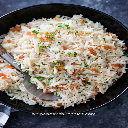

In [515]:
img =load_img('web_pics/pilaf.jpg', target_size=(128,128))
preds = model.predict(np.array([img_to_array(img)/255]))
print(text_labels.iloc[np.argmax(preds[0])])
img

name    croissant
Name: 12, dtype: object


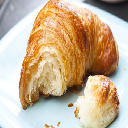

In [512]:
img = load_img('web_pics/crossaint.jpg', target_size=(128,128))
preds = model.predict(np.array([img_to_array(img)/255]))
print(text_labels.iloc[np.argmax(preds[0])])
img

## Convert Classifier to Object Detector

In [538]:
def sliding_window(image, step, ws):
    # slide a window across the image
    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            # yield the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])
            
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        w = int(image.shape[1] / scale)
        image = cv2.resize(image, (w,w))
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

In [762]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.1):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = area

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

In [763]:
def detect_food(img):
    WIDTH = 128
    PYR_SCALE = 1.5
    WIN_STEP = 16
    ROI_SIZE = (128,128)
    INPUT_SIZE = (128, 128)
    rois = []
    locs = []
    (H, W) = img.shape[:2]
    pyramid = image_pyramid(img, minSize=(128,128))
    for image in pyramid:
        scale = W / float(image.shape[1])
        for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
            x = int(x * scale)
            y = int(y * scale)
            w = int(ROI_SIZE[0] * scale)
            h = int(ROI_SIZE[1] * scale)
            roi = cv2.resize(roiOrig, INPUT_SIZE)
            roi = img_to_array(roi)
            rois.append(roi)
            locs.append((x, y, x + w, y + h))
            
    import time
    # convert the ROIs to a NumPy array
    rois = np.array(rois, dtype="float32")
    # classify each of the proposal ROIs and print how long the classifications took
    print("[INFO] classifying ROIs...")
    start = time.time()
    preds = model.predict(rois)
    end = time.time()
    print("[INFO] classifying ROIs took {:.5f} seconds".format(
        end - start))
    
    bbox_predictions = {}

    for i, p in enumerate(preds):
        # grab the prediction information for the current ROI
        predicted_label = np.argmax(p)

        # filter out weak detections by ensuring the predicted probability
        # is greater than the minimum probability
        if p[predicted_label] >= 0.995:

            # grab the bounding box associated with the prediction and
            # convert the coordinates
            box = locs[i]
            predicted_label_text = text_labels.iloc[predicted_label][0]

            L = bbox_predictions.get(predicted_label_text, [])
            L.append((box, p[predicted_label]))
            bbox_predictions[predicted_label_text] = L
    
    clone = img.copy()

    for item in bbox_predictions.keys():
        
        boxes = np.array([p[0] for p in bbox_predictions[item]])
        proba = np.array([p[1] for p in bbox_predictions[item]])
        boxes = non_max_suppression(boxes,proba)
        
        print('[FOOD DETECTED] ' +  item + ' ' + str(proba.max()))
        for (startX, startY, endX, endY) in boxes:
            # draw the bounding box and label on the image
            cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(clone, item, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
            break
            
    plt.imshow(np.clip(clone, a_max = 1, a_min=0))


[INFO] classifying ROIs...
[INFO] classifying ROIs took 3.36776 seconds
[FOOD DETECTED] dipping noodles 0.99914205
[FOOD DETECTED] rice 1.0
[FOOD DETECTED] miso soup 0.9995839
[FOOD DETECTED] grilled pacific saury  0.99976104


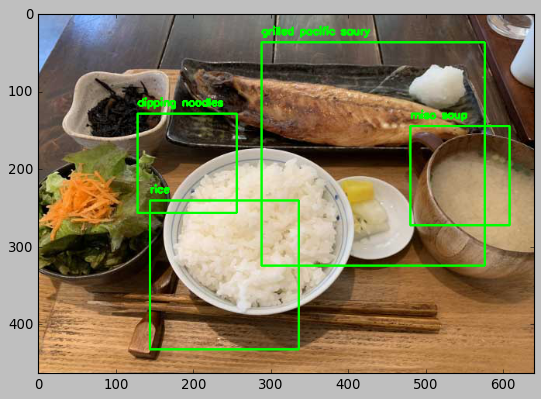

In [761]:
img = load_img('web_pics/jpfood.jpg')
img = img_to_array(img)/255
detect_food(img)

[INFO] classifying ROIs...
[INFO] classifying ROIs took 5.27601 seconds
[FOOD DETECTED] miso soup 0.9993405
[FOOD DETECTED] steamed egg hotchpotch 0.99999523
[FOOD DETECTED] rice 1.0


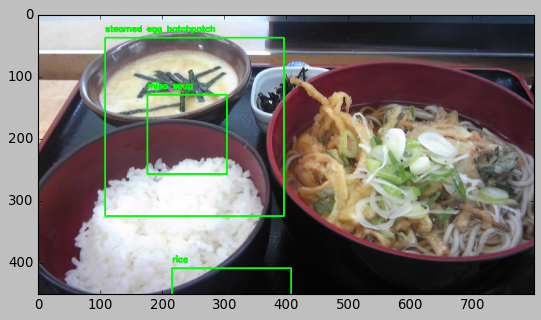

In [766]:
img = load_img('web_pics/setmeal.jpg')
img = img_to_array(img)/255
detect_food(img)

In [ ]:
food_dict = {'french fries': {'protein': 0, 'carb': 20, 'fat': 999}}

[INFO] classifying ROIs...
[INFO] classifying ROIs took 5.37841 seconds
[FOOD DETECTED] french fries 0.99999464
[FOOD DETECTED] hamburger 0.99999833


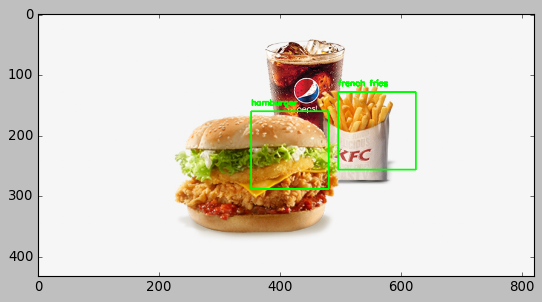

In [764]:
img = load_img('web_pics/fastfood_meal.jpg')
img = img_to_array(img)/255
detect_food(img)

[INFO] classifying ROIs...
[INFO] classifying ROIs took 2.58433 seconds
[FOOD DETECTED] croissant 1.0


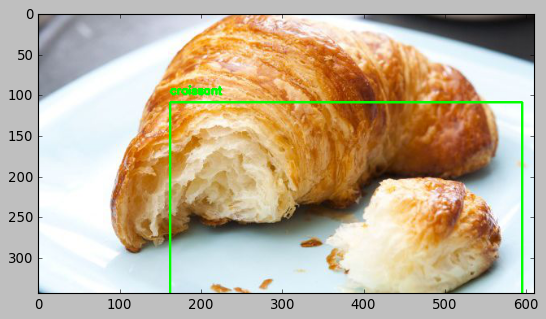

In [765]:
img = load_img('web_pics/crossaint.jpg')
img = img_to_array(img)/255
detect_food(img)